In [1]:
# Imports
import os
import warnings
from io import StringIO
import pandas as pd
import gcsfs
from google.cloud import storage, bigquery
from datasets import Dataset, load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    ProgressCallback
)
import torch
import evaluate
import inspect
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score
import matplotlib.pyplot as plt

In [2]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/mnt/disks/data/diss_bucket_key.json"
# Turn off all warnings
warnings.filterwarnings('ignore')

In [3]:
# Detect number of GPUs
gpus = torch.cuda.device_count()
print(f"Number of GPUs available: {gpus}")
print(torch.cuda.get_device_name(0))

Number of GPUs available: 1
NVIDIA A100-SXM4-40GB


In [4]:
# === Disable Weights & Biases to avoid API prompts ===
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "dryrun"

In [6]:
# === Configuration ===
PROJECT_ID = "bamboo-mercury-462915-f0"
BQ_DATASET = "edgar_sentiment"
BQ_TABLE = "filing_scores"
BQ_TABLE_EVAL = "filing_scores_evaluation"
REGION = "europe-west2"
OUTPUT_DIR = f"gs://diss_market_data/finbert-finetune-output"
# MODEL_NAME = "yiyanghkust/finbert-tone"
NUM_LABELS = 3

# 🔁 Optional: Try stronger models if F1 plateaus
# MODEL_NAME = "ProsusAI/finbert"  # financial-news specific FinBERT
MODEL_NAME = "microsoft/deberta-v3-base"  # smaller DeBERTa finetuned on financial news

In [7]:
# === Environment Variables for HPC ===
os.environ["GOOGLE_CLOUD_PROJECT"] = PROJECT_ID
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "dryrun"
os.environ["NCCL_DEBUG"] = "INFO"
os.environ["NCCL_P2P_DISABLE"] = "1"

In [12]:
# === Extract data from BigQuery for training ===
bq_client = bigquery.Client()
query = f"""(SELECT chunk_text, sentiment_score, sentiment_label FROM `{PROJECT_ID}.{BQ_DATASET}.{BQ_TABLE}`
        where sentiment_label IN ('Positive'))
        UNION ALL
        (SELECT chunk_text, sentiment_score, sentiment_label FROM `{PROJECT_ID}.{BQ_DATASET}.{BQ_TABLE}`
        where sentiment_label IN ('Negative') LIMIT 4500)
        UNION ALL
        (SELECT chunk_text, sentiment_score, sentiment_label FROM `{PROJECT_ID}.{BQ_DATASET}.{BQ_TABLE}`
        where sentiment_label IN ('Neutral') LIMIT 4500)
        """
df_filings = bq_client.query(query).to_dataframe()
print(f"Retrieved {len(df_filings)} rows from filings training table {BQ_DATASET}.{BQ_TABLE}")

Retrieved 12797 rows from filings training table edgar_sentiment.filing_scores


In [13]:
# === Extract data from BigQuery for evaluation ===
query = f"""SELECT chunk_text text, sentiment_label FROM `{PROJECT_ID}.{BQ_DATASET}.{BQ_TABLE_EVAL}`
        where sentiment_label IN ('Positive', 'Negative', 'Neutral')
        """
df_eval = bq_client.query(query).to_dataframe()
print(f"Retrieved {len(df_eval)} rows from evaluation table {BQ_DATASET}.{BQ_TABLE_EVAL}")

Retrieved 1298 rows from evaluation table edgar_sentiment.filing_scores_evaluation


In [14]:
# Gemini Labeled Filings in chunks
label_map = {"Negative": 2, "Neutral": 0, "Positive": 1}
df_filings['label'] = df_filings['sentiment_label'].map(label_map)
df_eval['label'] = df_eval['sentiment_label'].map(label_map)
df_eval.drop(columns=['sentiment_label'], inplace=True)

In [15]:
# # /financial-tweets-sentiment
# ds_tweets = load_dataset("TimKoornstra/financial-tweets-sentiment")
# df_tweets = pd.DataFrame(ds_tweets['train'])

In [35]:
# financial_phrasebank
df_phrasebank = pd.read_csv("/mnt/disks/data/project_data/Financial_Phrasebank_50__Agree.csv")

In [36]:
# Changing Labels to match -> {"Negative": 2, "Neutral": 0, "Positive": 1}
label_map = {"negative": 2, "neutral": 0, "positive": 1}
df_phrasebank['sentiment'] = df_phrasebank['label']
df_phrasebank['label'] = df_phrasebank['sentiment'].map(label_map)

In [37]:
df1 = df_filings[['chunk_text', 'label']].rename(columns={'chunk_text': 'text'})
# df2 = df_tweets[['tweet', 'sentiment']].rename(columns={'tweet': 'text', 'sentiment': 'label'})
df3 = df_phrasebank[['sentence', 'label']].rename(columns={'sentence': 'text'})

In [39]:
df_final = pd.concat([df1, df3])

In [40]:
df_final.columns, df_eval.columns

(Index(['text', 'label'], dtype='object'),
 Index(['text', 'label'], dtype='object'))

In [41]:
# === Convert to Hugging Face Dataset ===
train_dataset = Dataset.from_pandas(df_final[['text', 'label']])
eval_dataset = Dataset.from_pandas(df_eval[['text', 'label']])

In [42]:
# === Tokenization ===
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_batch(examples):
    return tokenizer(
        examples['text'],
        truncation=True,
        padding='longest',
        max_length=512
    )

# 🔁 Optional: Try stronger models if F1 plateaus
# MODEL_NAME = "ProsusAI/finbert"  # financial-news specific FinBERT
# MODEL_NAME = "mrm8488/deberta-v3-small-finetuned-financial-news-sentiment-analysis"  # smaller DeBERTa finetuned on financial news

In [43]:
tokenized_train = train_dataset.map(tokenize_batch, batched=True)
tokenized_eval = eval_dataset.map(tokenize_batch, batched=True)

Map:   0%|          | 0/17643 [00:00<?, ? examples/s]

Map:   0%|          | 0/1298 [00:00<?, ? examples/s]

In [44]:
# Filter to essential columns
def keep_features(ds):
    keep = ['input_ids','attention_mask','label']
    return ds.remove_columns([c for c in ds.column_names if c not in keep])
train_ds, eval_ds = keep_features(tokenized_train), keep_features(tokenized_eval)

In [45]:
# === Model Setup ===
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS)

# === Configure TrainingArguments ===
base_args = {
    'output_dir': OUTPUT_DIR,
    'num_train_epochs': 5,
    'per_device_train_batch_size': 4,
    'per_device_eval_batch_size': 8,
    'eval_steps': 100,
    'save_steps': 500,
    'logging_steps': 100,
    'learning_rate': 1e-5,
    'warmup_steps': 200,
    'load_best_model_at_end': True,
    'metric_for_best_model': 'eval_loss',
    'save_total_limit': 2,
    'fp16': True,
    'dataloader_num_workers': 4,
    'report_to': 'none',
    'label_smoothing_factor': 0.1,
    'gradient_accumulation_steps': 12,  # to maintain effective batch size

}

# Dynamically add supported strategies
sig = inspect.signature(TrainingArguments)
if 'evaluation_strategy' in sig.parameters and 'save_strategy' in sig.parameters:
    base_args['evaluation_strategy'] = 'steps'
    base_args['save_strategy'] = 'steps'
else:
    base_args.pop('load_best_model_at_end', None)
    base_args.pop('metric_for_best_model', None)

# Add progress bar settings if supported
if 'disable_tqdm' in sig.parameters:
    base_args['disable_tqdm'] = False
if 'progress_bar_refresh_rate' in sig.parameters:
    base_args['progress_bar_refresh_rate'] = 20

# Initialize TrainingArguments
valid_args = {k: v for k, v in base_args.items() if k in sig.parameters}
training_args = TrainingArguments(**valid_args)

# 🔁 Optional: Try stronger models if F1 plateaus
# MODEL_NAME = "ProsusAI/finbert"  # financial-news specific FinBERT
# MODEL_NAME = "mrm8488/deberta-v3-small-finetuned-financial-news-sentiment-analysis"  # smaller DeBERTa finetuned on financial news

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [46]:
# === Metrics ===
# Pre-load accuracy and F1 metrics
accuracy_metric = evaluate.load('accuracy')
f1_metric = evaluate.load('f1')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    # Compute accuracy
    acc = accuracy_metric.compute(predictions=preds, references=labels)
    # Compute weighted F1 score
    f1 = f1_metric.compute(predictions=preds, references=labels, average='weighted')
    return {
        'accuracy': acc['accuracy'],
        'f1': f1['f1']
    }

In [47]:
# === Trainer ===
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[ProgressCallback()]
)

# === Start training ===
trainer.train()

  0%|                                                                                                         …

Step,Training Loss
100,1.069700
200,0.873100
300,0.676800
400,0.593700
500,0.563900
600,0.550700
700,0.561900
800,0.509700
900,0.503400
1000,0.507900


{'loss': 1.0697, 'grad_norm': 2.6543445587158203, 'learning_rate': 4.95e-06, 'epoch': 0.27}
{'loss': 0.8731, 'grad_norm': 4.500887870788574, 'learning_rate': 9.950000000000001e-06, 'epoch': 0.54}
{'loss': 0.6768, 'grad_norm': 3.03271484375, 'learning_rate': 9.396341463414635e-06, 'epoch': 0.82}
{'loss': 0.5937, 'grad_norm': 4.5172553062438965, 'learning_rate': 8.78658536585366e-06, 'epoch': 1.09}
{'loss': 0.5639, 'grad_norm': 4.236894607543945, 'learning_rate': 8.176829268292684e-06, 'epoch': 1.36}
{'loss': 0.5507, 'grad_norm': 5.869775772094727, 'learning_rate': 7.567073170731708e-06, 'epoch': 1.63}
{'loss': 0.5619, 'grad_norm': 7.92147159576416, 'learning_rate': 6.957317073170732e-06, 'epoch': 1.9}
{'loss': 0.5097, 'grad_norm': 4.2141265869140625, 'learning_rate': 6.347560975609757e-06, 'epoch': 2.17}
{'loss': 0.5034, 'grad_norm': 4.910626411437988, 'learning_rate': 5.73780487804878e-06, 'epoch': 2.45}
{'loss': 0.5079, 'grad_norm': 4.5337700843811035, 'learning_rate': 5.1280487804878

TrainOutput(global_step=1840, training_loss=0.5568815822186677, metrics={'train_runtime': 1926.7789, 'train_samples_per_second': 45.784, 'train_steps_per_second': 0.955, 'total_flos': 2.311710516716796e+16, 'train_loss': 0.5568815822186677, 'epoch': 5.0})

In [48]:
# === Evaluate ===
trainer.evaluate()

  0%|                                                                                                         …

{'eval_loss': 0.9719311594963074,
 'eval_accuracy': 0.7372881355932204,
 'eval_f1': 0.7480227714737209,
 'eval_runtime': 6.4034,
 'eval_samples_per_second': 202.704,
 'eval_steps_per_second': 25.455,
 'epoch': 5.0}

In [31]:
# === Save Final Model ===
OUTPUT_DIR = "./deberta_filings"
trainer.save_model(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)
print(f"Model and checkpoints saved to: {OUTPUT_DIR}")

Model and checkpoints saved to: ./deberta_filings


In [32]:
# === Evaluate ===
results = trainer.evaluate()

# Print nicely
print("\n📊 Evaluation Metrics:")
for key, value in results.items():
    print(f"{key}: {value:.4f}")

# Run predictions on the evaluation dataset
predictions = trainer.predict(eval_ds)
pred_labels = predictions.predictions.argmax(axis=-1)
true_labels = predictions.label_ids

  0%|                                                                                                         …


📊 Evaluation Metrics:
eval_loss: 0.8676
eval_accuracy: 0.7635
eval_f1: 0.7714
eval_runtime: 6.8104
eval_samples_per_second: 190.5910
eval_steps_per_second: 23.9340
epoch: 5.0000


  0%|                                                                                                         …

[SUCCESS] Confusion matrix with metrics saved as 'confusion_matrix_eval_filings_deberta.png'

📋 Classification Report:
              precision    recall  f1-score   support

     Neutral       0.76      0.53      0.62       390
    Positive       0.47      0.92      0.62       205
    Negative       0.95      0.85      0.90       703

    accuracy                           0.76      1298
   macro avg       0.73      0.77      0.71      1298
weighted avg       0.82      0.76      0.77      1298



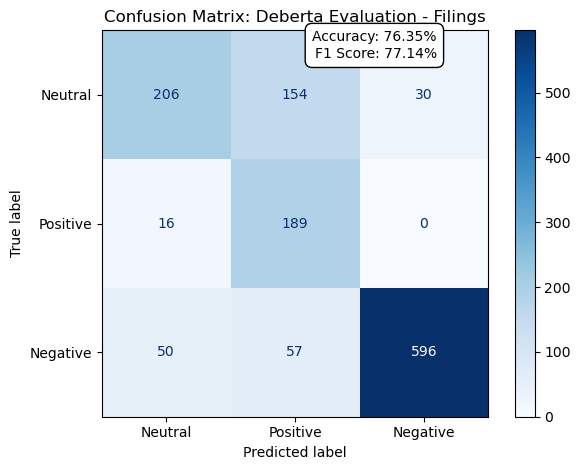

In [33]:
# === Compute metrics ===
accuracy = accuracy_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels, average='weighted')

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Neutral", "Positive", "Negative"])
disp.plot(cmap='Blues')

# === Add accuracy and F1 to the plot ===
plt.title("Confusion Matrix: Deberta Evaluation - Filings")
plt.text(
    2.1, -0.5,  # x, y position (tweak as needed)
    f"Accuracy: {accuracy:.2%}\nF1 Score: {f1:.2%}",
    fontsize=10,
    ha='right',
    va='top',
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')
)

plt.tight_layout()
plt.savefig("confusion_matrix_eval_filings_deberta.png")
print("[SUCCESS] Confusion matrix with metrics saved as 'confusion_matrix_eval_filings_deberta.png'")

# === Detailed classification report ===
from sklearn.metrics import classification_report
print("\n📋 Classification Report:")
print(classification_report(true_labels, pred_labels, target_names=["Neutral", "Positive", "Negative"]))

In [34]:
def upload_directory_to_gcs(local_dir, bucket_name, destination_dir):
    client = storage.Client()
    bucket = client.bucket(bucket_name)

    for root, _, files in os.walk(local_dir):
        for file in files:
            local_path = os.path.join(root, file)
            relative_path = os.path.relpath(local_path, local_dir)
            gcs_path = os.path.join(destination_dir, relative_path)

            blob = bucket.blob(gcs_path)
            blob.upload_from_filename(local_path)
            print(f"[UPLOAD] {local_path} → gs://{bucket_name}/{gcs_path}")

# === Upload Model Directory to GCS ===
GCS_BUCKET = "diss_market_data"
GCS_MODEL_PATH = "deberta_filings"
upload_directory_to_gcs(OUTPUT_DIR, GCS_BUCKET, GCS_MODEL_PATH)
print(f"[DONE] Model uploaded to gs://{GCS_BUCKET}/{GCS_MODEL_PATH}")

[UPLOAD] ./deberta_filings/tokenizer.json → gs://diss_market_data/deberta_filings/tokenizer.json
[UPLOAD] ./deberta_filings/config.json → gs://diss_market_data/deberta_filings/config.json
[UPLOAD] ./deberta_filings/tokenizer_config.json → gs://diss_market_data/deberta_filings/tokenizer_config.json
[UPLOAD] ./deberta_filings/spm.model → gs://diss_market_data/deberta_filings/spm.model
[UPLOAD] ./deberta_filings/special_tokens_map.json → gs://diss_market_data/deberta_filings/special_tokens_map.json
[UPLOAD] ./deberta_filings/added_tokens.json → gs://diss_market_data/deberta_filings/added_tokens.json
[UPLOAD] ./deberta_filings/training_args.bin → gs://diss_market_data/deberta_filings/training_args.bin
[UPLOAD] ./deberta_filings/model.safetensors → gs://diss_market_data/deberta_filings/model.safetensors
[DONE] Model uploaded to gs://diss_market_data/deberta_filings
